In [5]:
from data_loader import SegmentationDataModule, SegmentationTransform
import matplotlib.pyplot as plt
from models.unet import UNet
from models.lightning_model import SegmentationModel
from data_loader import class_to_rgb
import torch
import torch.nn as nn
from torchmetrics import MetricCollection

from configuration import LABEL_MAP

In [21]:
ds = SegmentationDataModule(batch_size=32, data_path="../data", transform=SegmentationTransform())
ds.setup()

In [22]:
data_loader = ds.val_dataloader()

In [23]:
metrics = MetricCollection([])
model = SegmentationModel.load_from_checkpoint(
    "../results/unet/checkpoints/unet_model.pth.ckpt",
    model=UNet(num_classes=12),
    lr=1e-3,
    metrics=metrics,
    vectorized_metrics=metrics,
    class_names=list(LABEL_MAP.values()),
    loss_fn=nn.CrossEntropyLoss(),
    scheduler_max_it=30,
    ).to(torch.device('cpu'))

(256, 256, 3)


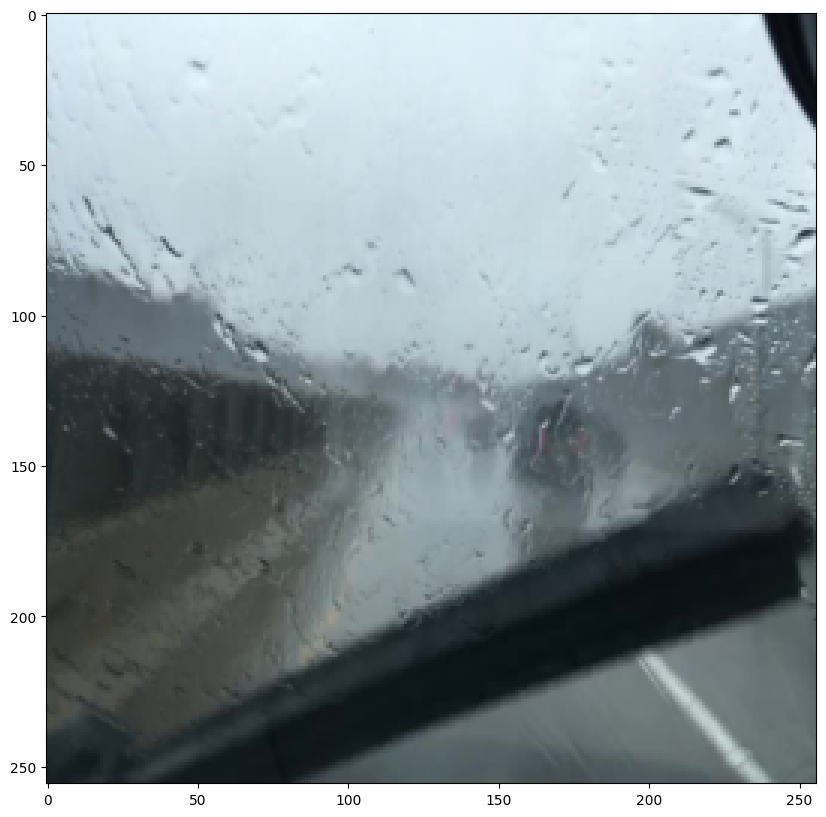

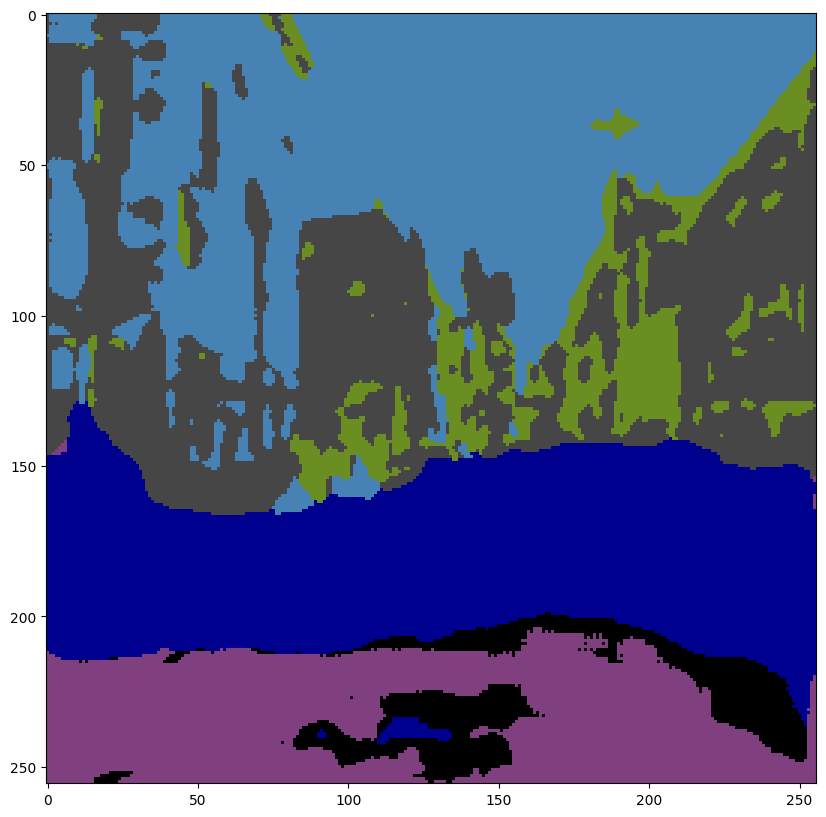

In [ ]:
count = 0
for image, mask in data_loader:
    if count == 0:
        plt.figure(figsize=(10, 10))
        plt.imshow(image[11].permute(1, 2, 0))

        output = model(image)
        print(class_to_rgb(output.argmax(dim=1)[0]).shape)

        plt.figure(figsize=(10, 10))
        plt.imshow(class_to_rgb(output.argmax(dim=1)[0]))
        break

In [10]:
import torch
from captum.attr import Saliency
import matplotlib.pyplot as plt
import numpy as np

def get_segmentation_saliency(model, image, target_class):
    """
    Compute saliency map for a given image and target_class in a segmentation model.

    Args:
        model (torch.nn.Module): Segmentation network outputting shape [B, C, H, W]
        image (torch.Tensor): Input image tensor shape [1, C, H, W], requires_grad=True
        target_class (int): Class index to compute saliency for

    Returns:
        np.ndarray: Normalized saliency heatmap shape [H, W]
    """
    image = image.detach().clone().requires_grad_(True)
    def forward_fn(x):
        out = model(x)  # [1, C, H, W]
        # Sum pixel-logits for the target class
        return out[:, target_class, :, :].sum(dim=(1, 2))

    saliency = Saliency(forward_fn)
    attributions = saliency.attribute(image)  # [1, C, H, W]

    # Take absolute max across channels
    sal = attributions[0].abs().detach().cpu().numpy()
    if sal.ndim == 3:  # when C > 1
        sal = sal.max(axis=0)

    # Normalize to [0, 1]
    sal = (sal - sal.min()) / (sal.max() - sal.min() + 1e-8)
    return sal

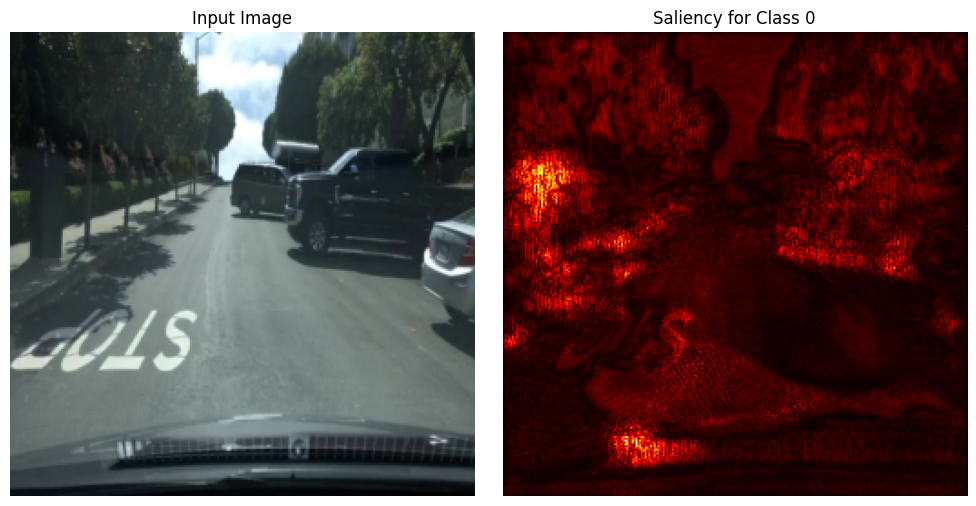

In [11]:
# Assumes `image` has shape [1, C, H, W]
image = image[1].unsqueeze(0).requires_grad_(True)

target_class = 0  # Example: show saliency for class 1

sal_map = get_segmentation_saliency(model.model, target_class=target_class, image=image)

# Plot saliency map over original image
input_image_np = image.squeeze().permute(1, 2, 0).detach().cpu().numpy()

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(input_image_np)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(sal_map, cmap="hot")
plt.title(f"Saliency for Class {target_class}")
plt.axis("off")

plt.tight_layout()
plt.show()

In [12]:
out_max = torch.argmax(image[0], dim=1, keepdim=True)

In [13]:
def agg_segmentation_wrapper(inp):
    model_out = model(inp)
    # Creates binary matrix with 1 for original argmax class for each pixel
    # and 0 otherwise. Note that this may change when the input is ablated
    # so we use the original argmax predicted above, out_max.
    selected_inds = torch.zeros_like(model_out[0:1]).scatter(1, out_max, 1)
    return (model_out * selected_inds).sum(dim=(2,3))

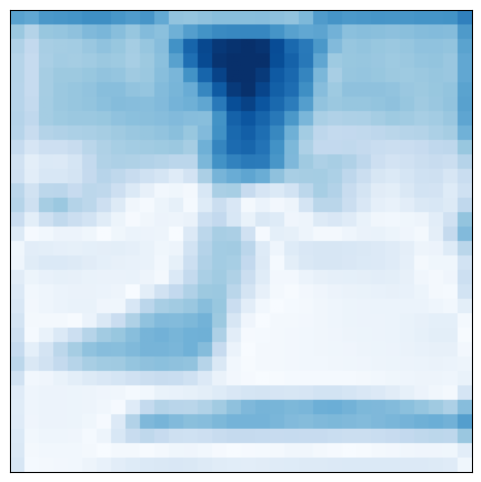

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [14]:
from captum.attr import LayerGradCam, FeatureAblation, LayerActivation, LayerAttribution
from captum.attr import visualization as viz

# Create wrapper to aggregate outputs
def agg_wrapper(input_tensor):
    output = model(input_tensor) 
    return (output * (output.argmax(1, keepdim=True) == target_class).float()).sum(dim=(2,3))

# Initialize GradCAM for a specific layer
grad_cam = LayerGradCam(agg_wrapper, model.model.down4.conv)  # Use relevant UNet layer

# Compute attributions
attributions = grad_cam.attribute(image, target=target_class)

# Upsample and visualize
upsampled_attr = LayerAttribution.interpolate(attributions, interpolate_dims=image.shape[2:])
viz.visualize_image_attr(upsampled_attr[0].cpu().permute(1,2,0).detach().numpy())


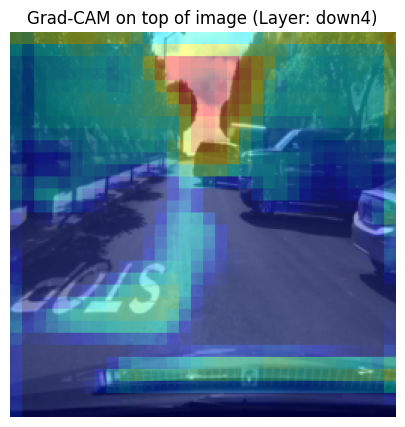

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from captum.attr import LayerGradCam, LayerAttribution

# Step 1: Grad-CAM attribution from down4
grad_cam = LayerGradCam(agg_wrapper, model.model.down4.conv)
attributions = grad_cam.attribute(image, target=target_class)

# Step 2: Upsample to input size
upsampled_attr = LayerAttribution.interpolate(attributions, interpolate_dims=image.shape[2:])
cam = upsampled_attr[0].cpu().detach().numpy()

# Step 3: Reduce to 2D heatmap (if multi-channel)
if cam.shape[0] > 1:
    cam = cam.mean(axis=0)
else:
    cam = cam[0]  # (H, W)

# Normalize to [0, 1]
cam = np.maximum(cam, 0)
cam = cam / (cam.max() + 1e-8)

# Step 4: Resize to match image size (if needed)
cam = cv2.resize(cam, (image.shape[3], image.shape[2]))

# Step 5: Convert input image for overlay
# Assuming normalized input, convert to numpy and scale to [0, 255]
img = image[0].cpu().permute(1, 2, 0).detach().numpy()
img = (img - img.min()) / (img.max() - img.min() + 1e-8)
img = np.uint8(255 * img)

# Step 6: Apply colormap to CAM
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Step 7: Overlay heatmap onto image
overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

# Step 8: Display
plt.figure(figsize=(10, 5))
plt.imshow(overlay)
plt.axis('off')
plt.title("Grad-CAM on top of image (Layer: down4)")
plt.show()

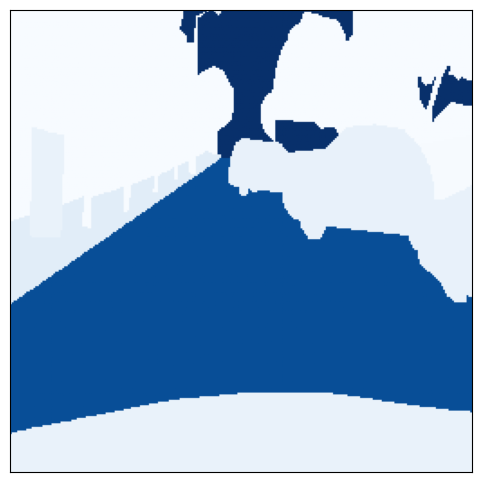

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [16]:
# Initialize Feature Ablation
ablator = FeatureAblation(agg_wrapper)

# Create feature mask (based on model predictions)
# _, mask = torch.max(model(image), 1)

# Compute attributions
ablation_attr = ablator.attribute(
    image,
    feature_mask=mask[1],
    perturbations_per_eval=1,
    target=target_class
)

# Visualize results
viz.visualize_image_attr(ablation_attr[0].cpu().permute(1,2,0).detach().numpy())


Class pixel counts: tensor([13762923.,  9757562.,   634764., 14154876.,  1343454., 10108214.,
          151147.,   527583.,  5944837.,   179887.,    15552.,  8955201.])


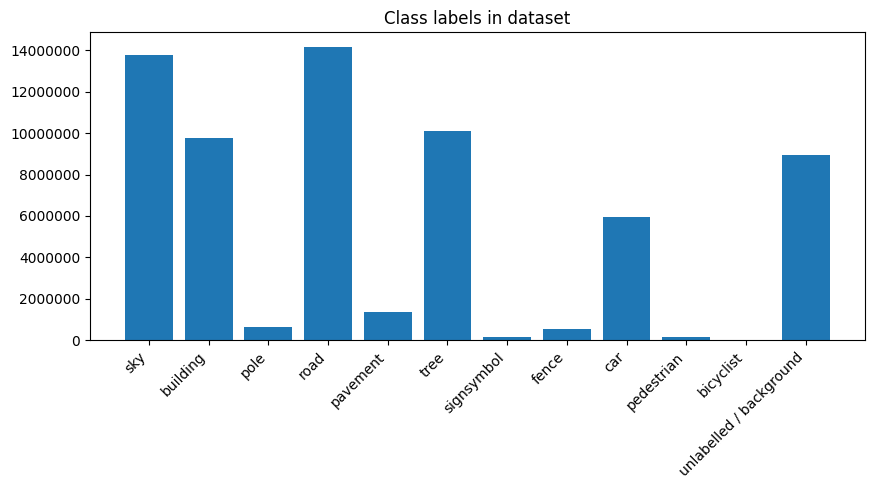

In [17]:
import torch
from configuration import LABEL_MAP
# Initialize count vector
class_counts = torch.zeros(12)
    
for images, masks in ds.train_dataloader():  # masks: (B, H, W)
    for cls in range(12):
        class_counts[cls] += (masks == cls).sum()

print("Class pixel counts:", class_counts)

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

plt.figure(figsize=(10, 4))
plt.title("Class labels in dataset")
plt.bar(list(LABEL_MAP.values()), class_counts)
plt.xticks(rotation=45, ha='right')

# Disable scientific notation on y-axis
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
plt.ticklabel_format(style='plain', axis='y')  # Another way to enforce plain style

plt.show()